# Import packages

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sma
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from scipy.stats import gaussian_kde
from scipy.stats.stats import pearsonr
import statsmodels.formula.api as sm
from scipy import stats
from sklearn.decomposition import PCA
import math
import scipy.stats as st
from matplotlib import colors as mcolors
import scipy as sp
from scipy import interpolate
%matplotlib inline 

# Paths to raw data

In [ ]:
# Psi values
Psi_values_ips = 'Psi_ips_path'   
Psi_values_endo =  'Psi_endo_path' 
single_cell_Psi_ips = 'single_cell_Psi_ips_path'       #re-formated (cancatenated) version of Psi_values_ips     
single_cell_Psi_endo = 'single_cell_Psi_endo_path'      #re-formated (cancatenated) version of Psi_values_endo     


#categories of exons
exon_categories_ips = 'categories_path_ips'  '
exon_categories_endo = 'categories_path_endo'


# features

# no methylation
features_without_methylation = 'features_no_meth_path'  
# mean methylation
features_on_mean_methylation_ips = 'features_mean_meth_ips_path' 
features_on_mean_methylation_endo = 'features_mean_meth_endo_path'
# single cell methylation
features_single_cell_methylation_ips = 'features_single_cell_methylation_ips_path' 
features_single_cell_methylation_endo = 'features_single_cell_methylation_endo_path'

# single cell methylation data

#single cell methylation
methylation_of_cells = 'methylation_of_cells_path'   
#methylation of individual genes of cells
methylation_of_individual_genes = 'methylation_of_individual_genes_path' 



# Main manuscript

# Show data, indroduce gene and cell model

# Functions

In [2]:
def binomial_std(x, n):
    return np.sqrt(n*x*(1-x))

def binomial_std_var(x, n):
    return n*x*(1-x)

def func(x, a):
    return a*np.sqrt(x*(1-x))

# Scripts

In [13]:
# load all Psi values of iPS cells 
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
 
#calculate mean and variance and individual difference from mean 
mean_Psi = np.mean(Psi_ips.T)
sd_Psi = np.std(Psi_ips.T)
var_Psi = np.var(Psi_ips.T)

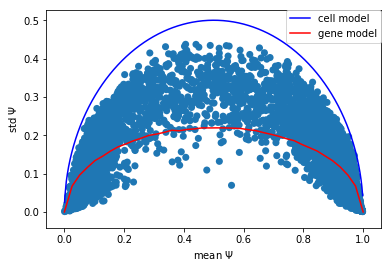

In [4]:
# calculate variance between x cells, draw isoform distribution for each cell from binomial distribution

mean_express = 5    # we only selected genes with at least 5 reads
number_cells = 11   # we only selected genes that were expressed in > 10 cells 
average_psi = np.linspace(0,1, 40)
variance_list = []
std_list_old = []

# make n_runs simulation runs and plot mean curve 
n_runs=400

for n in range(n_runs):
    std_list=[]
    for psi_curr in average_psi:
        cells_splice=[np.random.binomial(mean_express, psi_curr)/float(mean_express) for i in range(number_cells)]
        std_list.append(np.std(cells_splice))  
    
    # all others but first entry
    try:
        std_list_old=np.add(std_list,std_list_old)  
    # for first entry, create list for that
    except:
        std_list_old=std_list
    
#plot the standard deviation of each exon against its mean splicing rate  
x=mean_Psi
x_sort=np.sort(x.values)
y=sd_Psi
plt.scatter(x, y, s=50, edgecolor='')


#labeling of the plot 
plt.xlabel(r'mean $\Psi$')
plt.ylabel(r'std $\Psi$')


#plot binomial model, corresponds to cell model
plt.plot(x_sort, binomial_std(x_sort, 1), 'b', label='cell model')

#plot binomial model, corresponds to gene model 
plt.plot(average_psi, std_list_old/float(n_runs), "r", label='gene model')

plt.legend(bbox_to_anchor=(.912, .9),
           bbox_transform=plt.gcf().transFigure)


In [5]:
# make coloring according to classes with new catagories 
categories = pd.read_csv(exon_categories_ips , index_col=0, header=None)

# get the subsets
included = categories[categories[1]=='included'].index
excluded = categories[categories[1]=='excluded'].index
multimodal = categories[categories[1]=='multimodal'].index
overdispersed = categories[categories[1]=='overdispersed'].index
underdispersed= categories[categories[1]=='underdispersed'].index

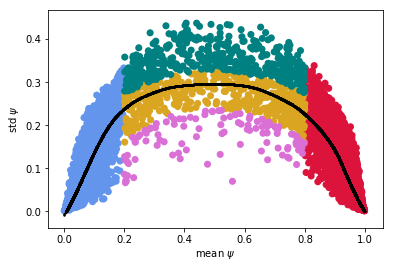

In [6]:
fig, ax1 = plt.subplots()

#plot the std
#ax1.scatter(x, y, s=50, edgecolor='', c=z,  cmap=plt.cm.coolwarm)
ax1.scatter(mean_Psi[included], sd_Psi[included], s=50, edgecolor='',c='crimson')
ax1.scatter(mean_Psi[excluded], sd_Psi[excluded], s=50, edgecolor='',c='cornflowerblue')
ax1.scatter(mean_Psi[multimodal], sd_Psi[multimodal], s=50, edgecolor='',c='goldenrod')
ax1.scatter(mean_Psi[overdispersed], sd_Psi[overdispersed], s=50, edgecolor='',c='teal')
ax1.scatter(mean_Psi[underdispersed], sd_Psi[underdispersed], s=50, edgecolor='',c='orchid')
ax1.set_ylabel(r'std $\psi$')
ax1.set_xlabel(r'mean $\psi$')


#include loess fit of the data
lowess = sma.nonparametric.lowess
w = lowess(sd_Psi, mean_Psi, frac=0.2)
ax1.scatter( w[:,0],w[:,1],c='black', s=2 )


# Linear models

# Functions

In [2]:
 # make linear model 
def linear_regression_nice(y, x, types="Psi", point_density=False, title=None, reshape=True, fig_name=None):   
    
    # Provides train/test indices to split data in train/test sets
    cv = KFold(shuffle=True)   
    lr = linear_model.Ridge()
    predicted = cross_val_predict(lr, x, y, cv=cv)
    
    if types=="Psi":
        #Psi values can only be between 0 and 1
        predicted=np.clip(predicted, 0, 1)
    elif types=="std":
        # standard deviation has the lower limit of 0
        predicted=np.clip(predicted, 0, 100)
    
    fig, ax = plt.subplots()
    
    # Calculate the point density for the shading of the plot 
    
    # for some imput data reshaping is necessary, this depends if the data is in the format of 
    # a list of lists or an array
    if reshape:
        predicted_new=[entry[0] for entry in predicted]
        y_new = [entry[0] for entry in y.values]

        xy = np.vstack([y_new,predicted_new])
        z = gaussian_kde(xy)(xy)
    else:
        xy = np.vstack([y,predicted])
        z = gaussian_kde(xy)(xy)

        
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
        
    plot_z = z[idx]
    plot_x = predicted[idx] 
    plot_y = y.values[idx] 
        

    # set everything below 0.1 to 0 for the coloring, as the coloring follows a gaussian distribution it
    # is not going to be exactly 0. Therefore, we set very small values to 0 to declutter the plot. 
    plot_z_new = [entry if entry > 0.1 else 0 for entry in plot_z]
    
    #ax.scatter(y_new, predicted_new, c=z, s=100, edgecolor='', cmap=plt.cm.Blues)
    ax.scatter(plot_y, plot_x, c=plot_z, s=1, edgecolor='', cmap=plt.cm.Greys, vmin=0, vmax=20)
    
    #calculate pearson correlation
    R=pearsonr(plot_y, plot_x)[0]
    #square the pearson R
    R_squared = R*R
    
    if types=="std":
        ax.set_xlabel(r'std Observed')
        ax.set_ylabel(r'std Predicted')
        ax.text(.15, 0.3, 'Pearson $R^2$= %.3f ' % (R_squared ))
        
    elif types=="Psi":
        ax.set_xlabel(r'$\Psi$ Observed')
        ax.set_ylabel(r'$\Psi$ Predicted')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(.65, 0.03, 'Pearson $R^2$= %.3f ' % (R_squared ))
    

In [3]:
def most_important_features_nice(y,x, fig_name):
    combined_test_sd=pd.concat([y,x ], axis=1)
    
    #remove rows with Nan
    combined_test_sd_corr=combined_test_sd.dropna()
    y_in=combined_test_sd_corr[combined_test_sd_corr.columns[0]]
    try:
        del combined_test_sd_corr[combined_test_sd_corr.columns[0]]
    except:
        pass


    score_dict_sd={}
    summary_dict_sd={}

    for name in combined_test_sd_corr.columns:
    
    
        #make prediction and calculate R
        # y was defined above 
        x_in=combined_test_sd_corr[name]
        x_copy=x_in
    
        # second test with sm.OLS
        # add constant to model mean
        x_copy_new = sma.add_constant(x_copy)
    
        #test model
        result_con = sm.OLS( y_in.values, np.asarray(x_copy_new, dtype='float') ).fit()
        #summary_dict_sd[name]=result_con
        try:
            score_dict_sd[name]=[result_con.params[1], result_con.rsquared, result_con.pvalues]
        except:
            # sometimes params is 0
            score_dict_sd[name]=[0, result_con.rsquared, result_con.pvalues]
        
    # make dataframe from dict
    R_df=pd.DataFrame.from_dict(score_dict_sd, orient="index")
    R_df.columns=["effect", "Pearson R", "p_value"]                                                                                                                                                                                                
    
    # get effect by multipling with std
    effect = R_df["effect"] * np.std(x) 
    
    # make new colum with sign
    sign = effect.copy() 
    sign[sign >= 0] = 1
    sign[sign < 0] = -1
    
    
    total_table = pd.concat([abs(effect), sign, R_df["Pearson R"], R_df["p_value"]], axis=1)
    total_table.columns = ["effect size", "sign", "Pearson R", "p_value" ]
    # sort after abs
    total_table = total_table.sort_values(by="Pearson R" , ascending=False)
    

    return R_df, total_table


In [4]:
def preprocess_single(x, y):
    #remove NaN genes
    x = x.dropna()  
    y = y.dropna()  
    common_genes=list(set(x.index)&set(y.index))
    x_new=x.T[common_genes].T
    y_new=y.T[common_genes].T
    
    return x_new, y_new 

In [13]:
def make_bar_plot_3(no_meth_ips, no_meth_endo, mean_meth_ips, mean_meth_endo, meth_ips, meth_endo, title, error_type, y_len):
    # data to plot
    n_groups = 2
    mean_no_meth_ips= np.mean(no_meth_ips)
    mean_no_meth_endo = np.mean(no_meth_endo)
    mean_mean_meth_ips = np.mean(mean_meth_ips)
    mean_mean_meth_endo = np.mean(mean_meth_endo)
    mean_with_meth_ips = np.mean(meth_ips)
    mean_with_meth_endo = np.mean(meth_endo)

    if error_type == "std":
        std_no_meth_ips = np.std(no_meth_ips)
        std_no_meth_endo = np.std(no_meth_endo)
        std_meth_ips = np.std(meth_ips)
        std_meth_endo = np.std(meth_endo)
    # confidence intervall
    elif error_type == "ci":
        std_no_meth_ips = 1.96*st.sem(no_meth_ips)
        std_no_meth_endo = 1.96*st.sem(no_meth_endo)
        std_mean_meth_ips = 1.96*st.sem(mean_meth_ips)
        std_mean_meth_endo = 1.96*st.sem(mean_meth_endo)
        std_meth_ips = 1.96*st.sem(meth_ips)
        std_meth_endo = 1.96*st.sem(meth_endo)


    means_no_meth = (mean_no_meth_ips, mean_no_meth_endo)
    means_with_meth = (mean_with_meth_ips, mean_with_meth_endo)   
    means_mean_meth = (mean_mean_meth_ips, mean_mean_meth_endo)
    std_no_meth = (std_no_meth_ips, std_no_meth_endo)
    std_meth = (std_meth_ips, std_meth_endo)
    std_mean_meth = (std_mean_meth_ips, std_mean_meth_endo)

    # create plot
    fig, ax = plt.subplots()
    index = 0.8*np.arange(n_groups)
    bar_width = 0.2
    opacity = 1

    rects1 = ax.bar(index, means_no_meth, bar_width,
                     alpha=opacity,
                     color='blue',
                     yerr=std_no_meth,
                     capsize=4,
                     label='no methylation')
    
    rects2 = ax.bar(index + bar_width, means_mean_meth, bar_width,
                    alpha=opacity,
                    color=mcolors.to_rgba("green"),
                    yerr=std_mean_meth, 
                    capsize=4,
                    label='mean methylation')

    rects3 = ax.bar(index + 2*bar_width, means_with_meth, bar_width,
                     alpha=opacity,
                     color=mcolors.to_rgba("red"),
                     yerr=std_meth, 
                     capsize=4,
                     label='methylation')
    


    plt.ylim(0.5,0.8)
    plt.ylabel('Pearson $R^2$')
    plt.xticks(index + 1*bar_width, ('iPS', 'endo'))
    plt.legend()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    leg = plt.legend(bbox_to_anchor=(1, 1),bbox_transform=plt.gcf().transFigure)
    leg.get_frame().set_linewidth(0.0)
    
    plt.tight_layout()
    


    
    plt.show()

In [ ]:
def autolabel(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects:
        width = rect.get_width()
        if width != 0:
            ax.text(0.003, rect.get_y() + rect.get_height()/10. ,'%s' % R_df.index[m], ha='left', va='bottom')

        m += 1

In [ ]:
def autolabel2(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects:
        width = rect.get_width()
        if width != 0:
            ax.text(-0.003, rect.get_y() + rect.get_height()/10. ,'%s' % R_df.index[m], ha='right', va='bottom')

        m += 1

In [ ]:
def make_feature_block(R_df, title, arrow = True): 

    # transoform features 
    negative_data = []
    positive_data = []
    for feature in R_df.index[:15]:
        if R_df["sign"][feature] == 1.:
            positive_data.append(R_df["Pearson R"][feature])
            negative_data.append(0)
        if R_df["sign"][feature] == -1.:
            negative_data.append(- R_df["Pearson R"][feature])
            positive_data.append(0)

    x = range(15)[::-1]
    fig = plt.figure()
    ax = plt.subplot(111)
    rects1= ax.barh(x, negative_data, align='edge', color='sienna', ecolor='black', alpha=0.7)
    rects2 = ax.barh(x, positive_data, align='edge', color='cornflowerblue', ecolor='black',alpha=0.7)
    #ax.plot([0,10], [0,0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axvline(x=0., color="black")
    autolabel(rects1, R_df, ax)
    autolabel2(rects2, R_df, ax)
    
    ax.set_xlabel('Pearson $R^2$')
    
    
    if arrow:

        #change labels to positive
        ax.set_xlim(-0.15)
        labels = ax.get_xticks().tolist()
        labels = [str(entry) for entry in labels]
        labels[0] = "0.2"
        labels[1] = "0.1"
        ax.set_xticklabels(labels)
        
    else:
        ax.set_xlim(-0.08)
        labels = ax.get_xticks().tolist()
        labels = [str(entry) for entry in labels]
        labels[0] = "0.08"
        labels[1] = "0.06"
        labels[2] = "0.04"
        labels[3] = "0.02"
        ax.set_xticklabels(labels)
    

In [50]:
def get_components(pca, indexes):

    #return principle components
    #largerst one
    d = {'contribution' : pd.Series(pca.components_[0], index=indexes)   
       }

    PC_df = pd.DataFrame(d)
    PC1=PC_df.sort_values(by='contribution', ascending=False)
    
    #second largest
    d2 = {'contribution' : pd.Series(pca.components_[1], index=indexes)   
       }

    PC2_df = pd.DataFrame(d2)
    PC2=PC2_df.abs().sort_values(by='contribution', ascending=False)

    return PC1, PC2

In [64]:
# make rainbow plot 
def autolabel_PCA(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects:
            width = rect.get_width()
            if width != 0:
                ax.text(0.003, rect.get_y() + rect.get_height()/3. ,'%s' % R_df.index[m], ha='left', va='bottom')
            m += 1

def autolabel2_PCA(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects[5:]:
        width = rect.get_width()
        if width != 0:
            ax.text(-0.003, rect.get_y() + rect.get_height()/3. ,'%s' % R_df.index[m], ha='right', va='bottom')
        m += 1
        


def make_feature_block_PCA( title, arrow = True): 
    
    # transoform features 
    negative_data = PC1[-5:][::-1].values
    zero_list = [0,0,0,0,0]
    negative_data = np.append(negative_data ,zero_list)
    positive_data = PC1[:5].values
    positive_data = np.append(zero_list, positive_data)

    x = range(10)[::-1]
    fig = plt.figure()
    ax = plt.subplot(111)
    rects1= ax.barh(x, negative_data, align='edge', color='sienna', ecolor='black', alpha=0.7)
    rects2 = ax.barh(x, positive_data, align='edge', color='cornflowerblue', ecolor='black',alpha=0.7)
    #ax.plot([0,10], [0,0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axvline(x=0., color="black")
    autolabel_PCA(rects1, PC1[-5:][::-1], ax)
    autolabel2_PCA(rects2, PC1, ax)
    
    ax.set_xlabel('contribution to PC 1')
    


In [54]:
def autolabel_feat(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects:
        width = rect.get_width()
        if width != 0:
            ax.text(0.01, rect.get_y() + rect.get_height()/10. ,'%s' % R_df.index[m], ha='left', va='bottom')

        m += 1

def autolabel2_feat(rects, R_df, ax):
    """
    Attach a text label above each bar displaying its height
    """
    m = 0
    for rect in rects:
        width = rect.get_width()
        if width != 0:
            ax.text(-0.01, rect.get_y() + rect.get_height()/10. ,'%s' % R_df.index[m], ha='right', va='bottom')

        m += 1

# Scripts

# No methylation

# iPS cells

In [ ]:
#load each cell indiviually and concatenate them 
features_no_methylation = pd.read_csv( features_without_methylation, index_col=0)  
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
# select the corresponding feature file 
counter = 0

for input_name in Psi_ips.columns:
    
    #get corresponding Psis
    current_Psi = Psi_ips[input_name]
    current_feature = features_no_methylation
    
    #remove Nans
    current_feature_proc, current_Psi_proc= preprocess_single( current_feature, current_Psi)
    
    #append to big dataframe 
    if counter == 0:
        df_feat_total = current_feature_proc
        current_Psi_total = current_Psi_proc
        counter += 1
    else:
        df_feat_total = pd.concat([df_feat_total ,current_feature_proc]) 
        current_Psi_total = pd.concat([current_Psi_total ,current_Psi_proc])


In [ ]:
# excecute function to get four different splits for the data 
m = 0
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_no_meth_ips_" + str(m)
    
    linear_regression_nice( current_Psi_total,df_feat_total, types="Psi",  fig_name=fig_name_curr, reshape=False)
    most_important_features_nice(current_Psi_total,df_feat_total, fig_name_curr)
    m += 1

# Endodermal cells

In [ ]:
#load each cell indiviually and concatenate them 
features_no_methylation = pd.read_csv( features_without_methylation, index_col=0)  
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)

# select the corresponding feature file 
counter = 0

for input_name in Psi_endo.columns:
    
    #get corresponding Psis
    current_Psi = Psi_endo[input_name]
    current_feature = features_no_methylation
    
    #remove Nans
    current_feature_proc, current_Psi_proc= preprocess_single( current_feature, current_Psi)
    
    #append to big dataframe 
    if counter == 0:
        df_feat_total_endo = current_feature_proc
        current_Psi_total_endo = current_Psi_proc
        counter += 1
    else:
        df_feat_total_endo = pd.concat([df_feat_total_endo ,current_feature_proc]) 
        current_Psi_total_endo = pd.concat([current_Psi_total_endo ,current_Psi_proc])


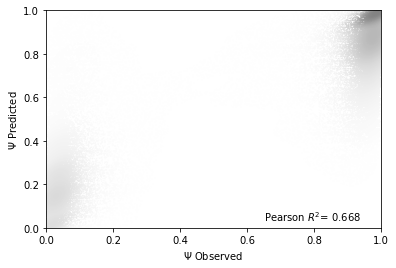

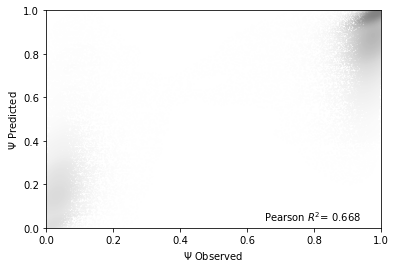

In [ ]:
# excecute function to get four different splits for the data
m = 0
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_no_meth_endo_" + str(m)
    
    linear_regression_nice( current_Psi_total_endo,df_feat_total_endo, types="Psi",  fig_name=fig_name_curr, reshape=False)
    most_important_features_nice(current_Psi_total_endo,df_feat_total_endo, fig_name_curr)
    m += 1

# Mean Meth 


# iPS cells

In [ ]:
#load each cell indiviually and concatenate them 
features_mean_methylation = pd.read_csv(features_on_mean_methylation_ips, index_col=0)
# fill NAs with mean of column
features_mean_methylation_filled = features_mean_methylation.fillna(features_mean_methylation.mean()) 

Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
# select the corresponding feature file 
counter = 0

for input_name in Psi_ips.columns:
    print input_name
    
    #get corresponding Psis
    current_Psi = Psi_ips[input_name]
    current_feature = features_mean_methylation_filled
    
    #remove Nans
    current_feature_proc, current_Psi_proc= preprocess_single( current_feature, current_Psi)
    
    #append to big dataframe 
    if counter == 0:
        df_feat_total_mean = current_feature_proc
        current_Psi_total_mean = current_Psi_proc
        counter += 1
    else:
        df_feat_total_mean = pd.concat([df_feat_total_mean ,current_feature_proc]) 
        current_Psi_total_mean = pd.concat([current_Psi_total_mean ,current_Psi_proc])


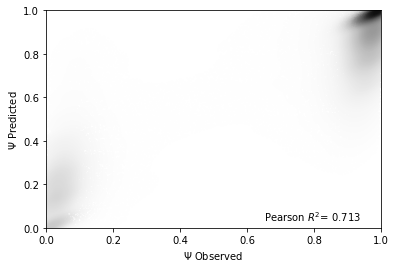

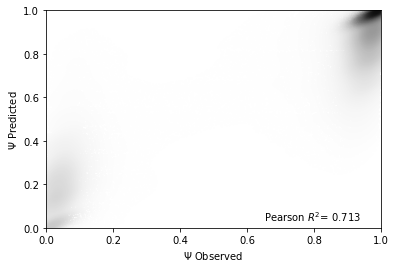

In [ ]:
# excecute function to get four different splits for the data
m = 0
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_mean_meth_ips_" + str(m)
    
    linear_regression_nice(current_Psi_total_mean, df_feat_total_mean,  types="Psi",  reshape=False, fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_mean, df_feat_total_mean, fig_name_curr)
    m += 1

# Endodermal cells

In [ ]:
#load each cell indiviually and concatenate them 
features_mean_methylation = pd.read_csv(features_on_mean_methylation_endo, index_col=0)
# fill NAs with mean of column
features_mean_methylation_filled = features_mean_methylation.fillna(features_mean_methylation.mean()) 

Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)
# select the corresponding feature file 
counter = 0

for input_name in Psi_endo.columns:
    print input_name
    
    #get corresponding Psis
    current_Psi = Psi_endo[input_name]
    current_feature = features_mean_methylation_filled
    
    #remove Nans
    current_feature_proc, current_Psi_proc= preprocess_single( current_feature, current_Psi)
    
    #append to big dataframe 
    if counter == 0:
        df_feat_total_mean_endo = current_feature_proc
        current_Psi_total_mean_endo = current_Psi_proc
        counter += 1
    else:
        df_feat_total_mean_endo = pd.concat([df_feat_total_mean_endo ,current_feature_proc]) 
        current_Psi_total_mean_endo = pd.concat([current_Psi_total_mean_endo ,current_Psi_proc])


In [ ]:
# excecute function to get four different splits for the data
m = 0
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_mean_meth_endo_" + str(m)
    
    linear_regression_nice(current_Psi_total_mean_endo, df_feat_total_mean_endo,  types="Psi", reshape=False, fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_mean_endo, df_feat_total_mean_endo, fig_name_curr)
    m += 1

# Single cell (sc) meth

# iPS cells

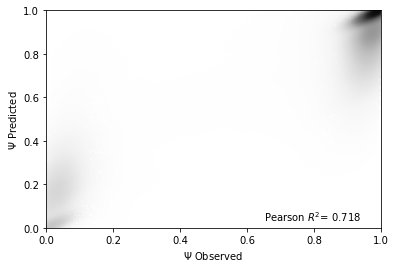

/nfs/research1/stegle/users/stlinker/conda-envs/tesnorflow_1/lib/python2.7/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/nfs/research1/stegle/users/stlinker/conda-envs/tesnorflow_1/lib/python2.7/site-packages/statsmodels/base/model.py:984: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2


In [ ]:
# Meth sc
y = pd.read_csv(features_single_cell_methylation_ips, index_col=0, header=None )
x = pd.read_csv(single_cell_Psi_ips, index_col=0)

# random shuffling

m = 1
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_sc_meth_ips_" + str(m)
    
    linear_regression_nice(y, x, types="Psi",  fig_name=fig_name_curr)
    most_important_features_nice(y,x, fig_name_curr)
    m += 1

# Endodermal cells

In [ ]:
# Meth sc
y_endo = pd.read_csv(features_single_cell_methylation_endo, index_col=0, header=None )
x_endo = pd.read_csv(single_cell_Psi_endo, index_col=0)


m = 0
for split in [1,2,3,4]:
    
    # make the linear model
    fig_name_curr = "Linear_model_sc_meth_endo_" + str(m)
    
    linear_regression_nice(y_endo, x_endo, types="Psi",  fig_name=fig_name_curr)
    most_important_features_nice(y_endo,x_endo, fig_name_curr)
    m += 1

# Bar plot for R of linear model

In [18]:
# Pearson R_squared data
# we filled example data from our paper in here

R_sc_ips = [0.704, 0.704, 0.704 ] 
R_sc_endo = [0.668, 0.668, 0.668 ] 

R_sc_ips_mean_meth = [0.713, 0.713, 0.713] 
R_sc_endo_mean_meth = [0.679,0.679, 0.679] 

R_sc_ips_meth = [0.718, 0.718, 0.718]  
R_sc_endo_meth = [0.684, 0.684, 0.684]   



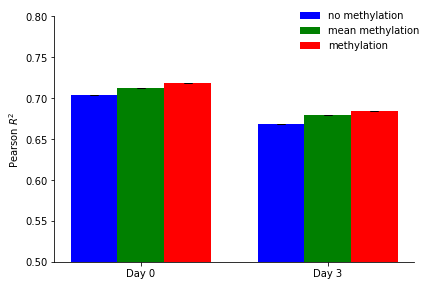

In [19]:
make_bar_plot_3(R_sc_ips, R_sc_endo, R_sc_ips_mean_meth, R_sc_endo_mean_meth, R_sc_ips_meth, R_sc_endo_meth, "sc_meth_comp_Psi", "ci", 1)


# Bar plots for features from linear model

In [ ]:
make_feature_block(R_bulk_ips_most_single, "features_bulk_ips_no_meth")

# PCA on features calculate features seperately

In [17]:
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)

Psi_all_columns = np.append(Psi_ips.columns, Psi_endo.columns)


In [ ]:
# make linear model on all single cells only use the most important feature function
annotation_file = pd.read_csv('annotation_file_path', sep='\t' , index_col=0 )

counter_R = 0
counter_effect = 0
name_list = []
for input_name in Psi_all_columns:
    try:
        
        day = input_name.split("_")[1][0]

        corresponding_name = anno.T[input_name.replace(".", "#")]["sample"]
        #get differentation state
        diff_state = corresponding_name.split("_")[1]
        cell = corresponding_name.split("_")[0]


        #get corresponding Psis
        if day == "7":
            current_Psi = Psi_ips[input_name]
            curr_day = 0
            feature_file_name = 'feature_path'+cell+'.csv'
            current_feature = pd.read_csv(feature_file_name, index_col=0 )

        elif day == "8":
            current_Psi = Psi_endo[input_name]  
            curr_day = 3
            feature_file_name = 'feature_path'+cell+'.csv'
            current_feature = pd.read_csv(feature_file_name, index_col=0 )
        #use sc methylation features     

        #remove Nans
        current_feature_proc, current_Psi_proc = preprocess_single( current_feature, current_Psi)
        # get feature file 
        R_df, total_table = most_important_features_nice(current_Psi_proc, current_feature_proc, fig_name=input_name)

        #append to total file
        curr_table_R = total_table["Pearson R"]
        if counter_R > 0:
            total_table_R = pd.concat([total_table_R, curr_table_R], axis=1)
        else:
            total_table_R = curr_table_R
            counter_R = 1

        curr_table_effect = total_table["effect size"] * total_table["sign"]
        if counter_effect > 0:
            total_table_effect = pd.concat([total_table_effect, curr_table_effect], axis=1)        
        else:
            total_table_effect = curr_table_effect
            counter_effect = 1
        name_list.append(input_name)
    except IOError:
        pass

    
    

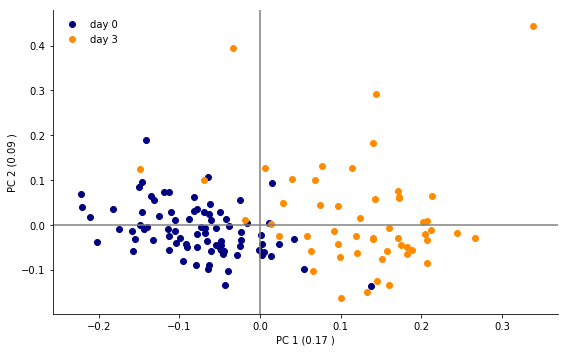

In [58]:
# plot PCA
total_table_effect.columns = name_list
pca = PCA(n_components=2)
pca.fit(total_table_effect.T)
fit_trans=pca.fit_transform(total_table_effect.T)

fit_trans.shape

#color the groups
n=0
transform_x_0=[]
transform_x_3=[]
transform_y_0=[]
transform_y_3=[]

# sort them after ips or endo state
for name in total_table_effect.columns:
    if name[6]=='7':
        transform_x_ips.append(fit_trans[n,0])
        transform_y_ips.append(fit_trans[n,1])
    elif name[6]=='8':
        transform_x_endo.append(fit_trans[n,0])
        transform_y_endo.append(fit_trans[n,1])
    n=n+1
    
    
colors = ['navy', 'darkorange']

plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
ips = [transform_x_ips, transform_y_ips ]
endo = [transform_x_endo, transform_y_endo ]
    
for color, day, target_name in zip(colors, [ips, endo], ["ips", "endo"]):
    ax.scatter(ips[0], endo[1], color=color, lw=1, label=target_name)

plt.legend(loc="best", shadow=False, scatterpoints=1, frameon=False)
ax.axhline(y=0., color="grey")
ax.axvline(x=0., color="grey")
plt.xlabel('PC 1 (%.2f )' % (pca.explained_variance_ratio_[0]))
plt.ylabel('PC 2 (%.2f )' % (pca.explained_variance_ratio_[1]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

# save PC1 as table

PC1, PC2= get_components(pca, total_table_effect.index)

# Ten most important PC

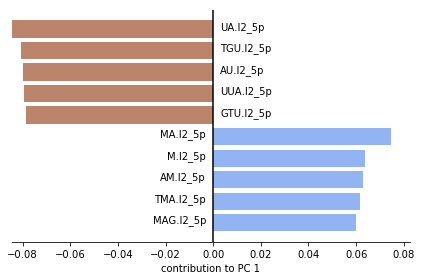

In [65]:
make_feature_block_PCA( "PCA_top5_pos_neg")

# Feature value of each cell with error bar

In [59]:
# get table with mean and std of it 

total_table_R_mean = np.mean(total_table_R.T)
total_table_R_std = np.std(total_table_R.T)

# order mean R after value
total_table_R_mean = total_table_R_mean.sort_values( ascending=False)
#order std in the same order
total_table_R_std =total_table_R_std[total_table_R_mean.index]
# use effect size to get the sign
total_table_effect_mean = np.mean(total_table_effect.T) 
total_table_effect_mean =total_table_effect_mean[total_table_R_mean.index]

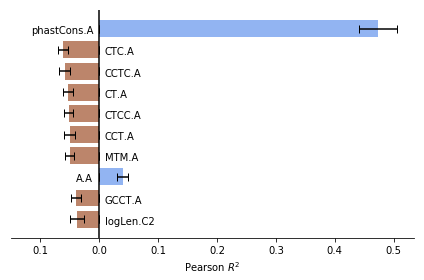

In [60]:
# Make rainbow plot

# transoform features 
negative_data = []
positive_data = []
negative_data_std = []
positive_data_std = []
for feature in total_table_R_mean[:10].index:
    if total_table_effect_mean[feature] >= 0:
        positive_data.append(total_table_R_mean[feature])
        negative_data.append(0)
        positive_data_std.append(total_table_R_std[feature])
        negative_data_std.append(0)
    elif total_table_effect_mean[feature] < 0:
        negative_data.append(- total_table_R_mean[feature])
        positive_data.append(0)
        negative_data_std.append( total_table_R_std[feature])
        positive_data_std.append(0)


x = range(10)[::-1]
fig = plt.figure()
ax = plt.subplot(111)
rects1= ax.barh(x, negative_data, align='edge', color='sienna', ecolor='black', alpha=0.7, xerr=negative_data_std, capsize=4)
rects2 = ax.barh(x, positive_data, align='edge', color='cornflowerblue', ecolor='black',alpha=0.7, xerr=positive_data_std, capsize=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plt.axvline(x=0., color="black")
autolabel_feat(rects1, total_table_R_std[:10], ax)
autolabel2_feat(rects2, total_table_R_std[:10], ax)
    
ax.set_xlabel('Pearson $R^2$')

ax.set_xlim(-0.15)
labels = ax.get_xticks().tolist()
labels = [str(entry) for entry in labels]
labels[0] = "0.2"
labels[1] = "0.1"
ax.set_xticklabels(labels)
        

# Prediction of bulk Psi for Supplement

In [ ]:
# check Psis
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)

#clalculate mean of cells 
Psi_ips_mean = np.mean(Psi_ips.T)
Psi_endo_mean = np.mean(Psi_endo.T)


In [ ]:
# For bulk no methylation iPs

features_no_methylation = pd.read_csv( features_without_methylation, index_col=0) 
current_Psi_total_no_meth_bulk = Psi_ips_mean


m = 0
for split in [1,2,3,4]:
    
    df_feat_total_no_meth_bulk_proc, current_Psi_total_no_meth_bulk_proc= preprocess_single( features_no_methylation, current_Psi_total_no_meth_bulk)
    
    # make the linear model
    fig_name_curr = "Linear_model_bulk_no_meth_ips_" + str(m)
    
    linear_regression_nice(current_Psi_total_no_meth_bulk_proc, df_feat_total_no_meth_bulk_proc,  types="Psi", reshape=False, fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_no_meth_bulk_proc, df_feat_total_no_meth_bulk_proc, fig_name_curr)
    m += 1

In [ ]:
# For bulk no methylation sc endo

features_no_methylation = pd.read_csv( features_without_methylation, index_col=0) 
current_Psi_total_no_meth_bulk_endo = Psi_endo_mean


m = 0
for split in [1,2,3,4]:
    
    df_feat_total_no_meth_bulk_proc, current_Psi_total_no_meth_bulk_endo_proc= preprocess_single( features_no_methylation, current_Psi_total_no_meth_bulk_endo)
    #df_feat_total_proc, current_Psi_proc, cross_split_new= preprocess_single2( df_feat_total, current_Psi_total, split)
    
    # make the linear model
    fig_name_curr = "Linear_model_bulk_no_meth_endo_" + str(m)
    
    linear_regression_nice(current_Psi_total_no_meth_bulk_endo_proc, df_feat_total_no_meth_bulk_proc,  types="Psi", reshape=False, fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_no_meth_bulk_endo_proc, df_feat_total_no_meth_bulk_proc, fig_name_curr)
    m += 1

In [ ]:
# For bulk mean methylation sc ips

features_mean_methylation = pd.read_csv(features_on_mean_methylation_ips, index_col=0)
current_Psi_total_mean_bulk = Psi_ips_mean


m = 0
for split in [1,2,3,4]:
    
    df_feat_total_mean_bulk_proc, current_Psi_total_mean_bulk_proc= preprocess_single( features_mean_methylation, current_Psi_total_mean_bulk)
  
    # make the linear model
    fig_name_curr = "Linear_model_bulk_mean_meth_ips_" + str(m)
    
    linear_regression_nice(current_Psi_total_mean_bulk_proc, df_feat_total_mean_bulk_proc,  types="Psi", reshape=False,  fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_mean_bulk_proc, df_feat_total_mean_bulk_proc, fig_name_curr)
    m += 1

In [ ]:
# For bulk mean methylation sc endo

features_mean_methylation_endo = pd.read_csv(features_on_mean_methylation_endo, index_col=0)
current_Psi_total_mean_bulk_endo = Psi_endo_mean


m = 0
for split in [1,2,3,4]:
    
    df_feat_total_mean_bulk_endo_proc, current_Psi_total_mean_bulk_endo_proc= preprocess_single( features_mean_methylation_endo, current_Psi_total_mean_bulk_endo)
  
    
    # make the linear model
    fig_name_curr = "Linear_model_bulk_mean_meth_endo_" + str(m)
    
    linear_regression_nice(current_Psi_total_mean_bulk_endo_proc, df_feat_total_mean_bulk_endo_proc,  types="Psi", reshape=False,  fig_name=fig_name_curr)
    most_important_features_nice(current_Psi_total_mean_bulk_endo_proc, df_feat_total_mean_bulk_endo_proc, fig_name_curr)
    m += 1


# Methylation distribution plot

In [80]:
# based on categories
cate = pd.read_csv(exon_categories_ips, index_col=0, header=None)

cate.columns = ["category"]
label_list_over_own=cate[cate["category"]=="overdispersed"].index
label_list_under_own=cate[cate["category"]=="underdispersed"].index
label_list_in_own=cate[cate["category"]=="included"].index
label_list_ex_own=cate[cate["category"]=="excluded"].index
label_list_mult_own=cate[cate["category"]=="multimodal"].index

# Psi dataframe only for one cell state
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_ips = Psi_ips.T

#load single cell methylation
single_cell_meth_dict = np.load(methylation_of_cells).item()
# load methylation of individual genes of cells
df_gene_meth=pd.read_csv(methylation_of_individual_genes, index_col=0)
df_gene_meth.index=[ entry.replace("#", ".") for entry in df_gene_meth.index]


In [84]:
# comparison of the mean meth state
z_over=[]
z_under=[]
z_alt_over=[]
z_alt_under=[]
z_in=[]
z_out=[]
z_alt_in=[]
z_alt_out=[]
z_mult=[]
z_alt_mult=[]

for i in label_list_over_own:
    name=i 
    z_over=np.append(z_over, df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    for cell_name in Psi_ips[name].dropna().index:
            cell_name=cell_name.replace(".", "#")
            z_alt_over=np.append(z_alt_over,single_cell_meth_dict[cell_name].T[name]["C1"] )

        
for i in label_list_under_own: 
    name=i 
    z_under=np.append(z_under, df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    for cell_name in Psi_ips[name].dropna().index:
            cell_name=cell_name.replace(".", "#")
            z_alt_under=np.append(z_alt_under,single_cell_meth_dict[cell_name].T[name]["C1"] )


for i in label_list_mult_own: 
    name=i 
    z_mult=np.append(z_mult, df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    for cell_name in Psi_ips[name].dropna().index:
            cell_name=cell_name.replace(".", "#")
            z_alt_mult=np.append(z_alt_mult,single_cell_meth_dict[cell_name].T[name]["C1"] )

for i in label_list_in_own:
    name=i 
    z_in=np.append(z_in, df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    for cell_name in Psi_ips[name].dropna().index:  
            cell_name_new=cell_name.replace(".", "#")
            z_alt_in=np.append(z_alt_in,single_cell_meth_dict[cell_name_new].T[name]["C1"] )

            
for i in label_list_ex_own: 
    name=i 
    z_out=np.append(z_out, df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    for cell_name in Psi_ips[name].dropna().index:      
            cell_name_new=cell_name.replace(".", "#")
            z_alt_out=np.append(z_alt_out,single_cell_meth_dict[cell_name_new].T[name]["C1"] )


        
z_under = z_under[np.logical_not(np.isnan(z_under))]
z_over = z_over[np.logical_not(np.isnan(z_over))]
z_alt_under = z_alt_under[np.logical_not(np.isnan(z_alt_under))]
z_alt_over = z_alt_over[np.logical_not(np.isnan(z_alt_over))]

In [85]:
z_in = z_in[np.logical_not(np.isnan(z_in))]
z_out = z_out[np.logical_not(np.isnan(z_out))]
z_alt_in = z_alt_in[np.logical_not(np.isnan(z_alt_in))]
z_alt_out = z_alt_out[np.logical_not(np.isnan(z_alt_out))]
z_mult = z_mult[np.logical_not(np.isnan(z_mult))]
z_alt_mult = z_alt_mult[np.logical_not(np.isnan(z_alt_mult))]

labels=[ "included", "excluded", "overdispersed", "multimodal", "underdispersed" ]
test=[ z_in, z_out, z_over, z_mult, z_under]
test2=[ z_alt_in, z_alt_out, z_alt_over, z_alt_mult, z_alt_under]

Ttest_indResult(statistic=33.246793385907701, pvalue=3.1092554002406614e-234)
Ttest_indResult(statistic=31.181688688530109, pvalue=2.5093783630969024e-207)


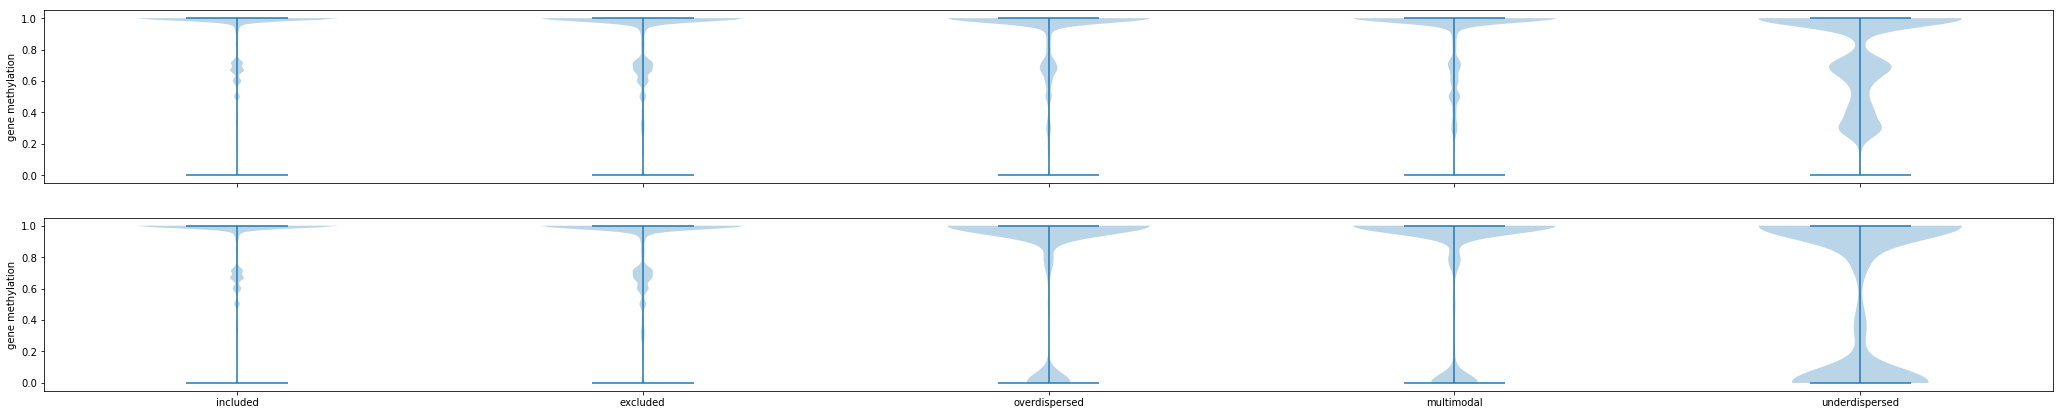

In [86]:
f, ax = plt.subplots(2, sharex=True, figsize=(36,7))
ax[0].set_ylabel("gene methylation")
ax[1].set_ylabel("gene methylation")


ax[0].set_xticklabels([ "included", "excluded", "overdispersed", "multimodal", "underdispersed" ])
ax[1].set_xticklabels([ "", "included", "excluded", "overdispersed", "multimodal", "underdispersed" ])

ax[0].violinplot(test)
ax[1].violinplot(test2)

print stats.ttest_ind(z_over, z_under)
print stats.ttest_ind(z_alt_over, z_alt_under)


# Change category plot

In [ ]:
def estimate_q(pv, m=None, verbose=False, lowmem=False, pi0=None):
    """
    Estimates q-values from p-values
    Args
    =====
    m: number of tests. If not specified m = pv.size
    verbose: print verbose messages? (default False)
    lowmem: use memory-efficient in-place algorithm
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
         For most GWAS this is not necessary, since pi0 is extremely likely to be
         1
    """
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    if m is None:
        m = float(len(pv))
    else:
        # the user has supplied an m
        m *= 1.0

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = sp.arange(0, 0.90, 0.01)
        counts = sp.array([(pv > i).sum() for i in sp.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = sp.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)
        if verbose:
            print("qvalues pi0=%.3f, estimated proportion of null features " % pi0)

        if pi0 > 1:
            if verbose:
                print("got pi0 > 1 (%.3f) while estimating qvalues, setting it to 1" % pi0)
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    if lowmem:
        # low memory version, only uses 1 pv and 1 qv matrices
        qv = sp.zeros((len(pv),))
        last_pv = pv.argmax()
        qv[last_pv] = (pi0*pv[last_pv]*m)/float(m)
        pv[last_pv] = -sp.inf
        prev_qv = last_pv
        for i in xrange(int(len(pv))-2, -1, -1):
            cur_max = pv.argmax()
            qv_i = (pi0*m*pv[cur_max]/float(i+1))
            pv[cur_max] = -sp.inf
            qv_i1 = prev_qv
            qv[cur_max] = min(qv_i, qv_i1)
            prev_qv = qv[cur_max]

    else:
        p_ordered = sp.argsort(pv)
        pv = pv[p_ordered]
        qv = pi0 * m/len(pv) * pv
        qv[-1] = min(qv[-1], 1.0)

        for i in xrange(len(pv)-2, -1, -1):
            qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

        # reorder qvalues
        qv_temp = qv.copy()
        qv = sp.zeros_like(qv)
        qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv

In [ ]:
# get the methyaltion for the different regions 
def get_meth_difference_regions(name):
 
    z_0_C1, z_0_I1_5p, z_0_I1_3p, z_0_A, z_0_I2_5p, z_I2_3p_C1, z_0_C2 = [], [], [], [], [], [], [] 
    
    variables = [z_0_C1, z_0_I1_5p, z_0_I1_3p, z_0_A, z_0_I2_5p, z_I2_3p_C1, z_0_C2]
    regions = ["C1", "I1_5p", "I1_3p", "A", "I2_5p", "I2_3p", "C2"] 
    # get distribution for day 0
    m = 0
    for curr_variable in variables:
        curr_region = regions[m]
        for cell_name in Psi_ips[name].dropna().index:      
            try:
                cell_name_new=cell_name.replace(".", "#")
                curr_variable = np.append(curr_variable, single_cell_meth_dict[cell_name_new].T[name][curr_region] )
            except:
                print "except"
                curr_variable = np.append(curr_variable, df_gene_meth[name].T[Psi_ips[name].dropna().index][cell_name])
        variables[m] = curr_variable
        m += 1
        
    return variables
    

In [68]:
# based on categories
cate_endo = pd.read_csv(exon_categories_endo, index_col=0, header=None)
cate_endo.columns = ["category"]
label_list_over_own_endo=cate_endo[cate_endo["category"]=="overdispersed"].index
label_list_under_own_endo=cate_endo[cate_endo["category"]=="underdispersed"].index
label_list_in_own_endo=cate_endo[cate_endo["category"]=="included"].index
label_list_ex_own_endo=cate_endo[cate_endo["category"]=="excluded"].index
label_list_mult_own_endo=cate_endo[cate_endo["category"]=="multimodal"].index

# based on categories
cate = pd.read_csv(exon_categories_ips, index_col=0, header=None)
cate.columns = ["category"]
label_list_over_own=cate[cate["category"]=="overdispersed"].index
label_list_under_own=cate[cate["category"]=="underdispersed"].index
label_list_in_own=cate[cate["category"]=="included"].index
label_list_ex_own=cate[cate["category"]=="excluded"].index
label_list_mult_own=cate[cate["category"]=="multimodal"].index

In [69]:
# look for genes that change from over to underdispersed
poss_day_endo = [label_list_over_own_endo, label_list_under_own_endo, label_list_in_own_endo, label_list_ex_own_endo, label_list_mult_own_endo  ]
poss_day_endo_name = ['over_endo', 'under_endo', 'in_endo', 'ex_endo', 'mult_endo']
poss_day_ips = [label_list_over_own, label_list_under_own, label_list_in_own, label_list_ex_own, label_list_mult_own  ]
poss_day_ips_name = ['over_ips', 'under_ips', 'in_ips', 'ex_ips', 'mult_ips']

transfer_dict = {}

for n in range(len(poss_day_endo)):
    for m in range(len(poss_day_ips)):
        # set new list for each new combination
        curr_list = []   
        for entry in poss_day_endo[n]:
            if entry in poss_day_ips[m]:
                curr_list.append(entry)
            # at the end write in dict
            transfer_dict[(poss_day_ips_name[m] + "_to_" + poss_day_endo_name[n]) ] = curr_list

In [ ]:
# plot the distributions 
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)
Psi_ips = Psi_ips.T
Psi_endo = Psi_endo.T

#load single cell methylation
single_cell_meth_dict = np.load(methylation_of_cells).item()
# load methylation of individual genes of cells
df_gene_meth=pd.read_csv(methylation_of_individual_genes, index_col=0)
df_gene_meth.index=[ entry.replace("#", ".") for entry in df_gene_meth.index]



# get table with mean meth of change and stay
title_list = []
mean_meth_dict_change_vs_stay_regions = {}
already_checked = {}

for title in transfer_dict:
    current_cat = title.split("_")[0]
    new_title = current_cat + "_to_" +  title.split("_")[3] + "_vs_stay_seven_regions"
    title_list.append(new_title)
    
    z_0_total = []
    z_1_total = []
    for gene_name in transfer_dict[title]:
        z_0 = get_meth_difference_regions(gene_name)
        try:
            z_0_total = [ np.append( z_0_total[n], z_0[n]) for n in range(len(z_0))]
        except:
             z_0_total= z_0
                
    title2 = current_cat + '_ips_to_' +current_cat + '_endo'  
    
    if title2 in already_checked.keys():
        z_1_total = already_checked[title2]
        print "already there"
    else:
        for gene_name in transfer_dict[title2]:
            z_1 = get_meth_difference_regions(gene_name)
            try:
                z_1_total = [ np.append( z_1_total[n], z_1[n]) for n in range(len(z_1))] 
            except:
                z_1_total = z_1
        # make dict with categories already encounterd
        already_checked[title2] = z_1_total          

    
    # make table with signigicances 
    for region_n in range(len(z_0_total)): 
    
        try:        
            z_0_curr = [value for value in z_0_total[region_n] if not math.isnan(value)]
            z_1_curr = [value for value in z_1_total[region_n] if not math.isnan(value)]
        
            # make tests
            # t test
            t_test = stats.ttest_ind(z_0_curr, z_1_curr)[1]
            wilcoxn_ranksum = stats.ranksums(z_0_curr, z_1_curr)[1]
        
            z_0_mean = np.mean(z_0_curr)
            z_1_mean = np.mean(z_1_curr)
        
            # write to table 
            try:
                mean_meth_dict_change_vs_stay_regions["mean change category"].append(z_0_mean) 
                mean_meth_dict_change_vs_stay_regions["mean all stay category"].append(z_1_mean)
                mean_meth_dict_change_vs_stay_regions["ttest_ind"].append(t_test) 
                mean_meth_dict_change_vs_stay_regions["wilcoxn_ranksum"].append(wilcoxn_ranksum)
            except:
                mean_meth_dict_change_vs_stay_regions["mean change category"] = [z_0_mean]
                mean_meth_dict_change_vs_stay_regions["mean all stay category"] = [z_1_mean]
                mean_meth_dict_change_vs_stay_regions["ttest_ind"] = [t_test]
                mean_meth_dict_change_vs_stay_regions["wilcoxn_ranksum"] = [wilcoxn_ranksum]
        
        except:
            pass
        

In [131]:
title_list = []
for title in transfer_dict:
    current_cat = title.split("_")[0]
    for add in [ "C1", "I1_5p", "I1_3p", "A", "I2_5p", "I2_3p", "C2" ]:
        new_title = current_cat + "_to_" +  title.split("_")[3] + "_vs_stay_" + add
        title_list.append(new_title)

test_title_list = [name for name in title_list if not "in_to_ex" in name] 
test_title_list2 = [name for name in test_title_list if not "ex_to_in" in name] 
test_title_list3 = [name for name in test_title_list2 if not "ex_to_under" in name] 
test_title_list4 = [name for name in test_title_list3 if not "over_to_under" in name]

compare_meth_df_change_vs_stay_regions = pd.DataFrame.from_dict(mean_meth_dict_change_vs_stay_regions)
compare_meth_df_change_vs_stay_regions.index = test_title_list4
compare_meth_df_change_vs_stay_regions.sort_index()


df_seven_region_statistics = compare_meth_df_change_vs_stay_regions
wilcosn_corrected  = estimate_q(df_seven_region_statistics["wilcoxn_ranksum"])
df_seven_region_statistics["wilcoxn_ranksum_corr"] = wilcosn_corrected

# get difference for all regions
difference_dict = {}
difference_df = df_seven_region_statistics['mean change category'] - df_seven_region_statistics['mean all stay category']
for entry in difference_df.index:
    name =  entry.split('_')[0] + '_to_' + entry.split('_')[2]
    try:
        difference_dict[name].append(difference_df[entry])
    except:
        difference_dict[name] = [difference_df[entry]]

In [142]:
# methylation difference
meth_mult_to_under = difference_dict['mult_to_under']
meth_mult_to_over = difference_dict['mult_to_over']
meth_mult_to_in = difference_dict['mult_to_in']
meth_mult_to_ex = difference_dict['mult_to_under']
meth_over_to_in = difference_dict['mult_to_ex']
meth_over_to_ex = difference_dict['over_to_ex']
meth_over_to_mult = difference_dict['over_to_mult']
meth_in_to_mult = difference_dict['in_to_mult']
meth_in_to_over = difference_dict['in_to_over']
meth_in_to_under = difference_dict['in_to_under']
meth_under_to_ex = difference_dict['under_to_ex']
meth_under_to_mult = difference_dict['under_to_mult']
meth_under_to_in =difference_dict['under_to_in']
meth_under_to_over = difference_dict['under_to_over']
meth_ex_to_over = difference_dict['ex_to_over']
meth_ex_to_mult = difference_dict['ex_to_mult']

y_name = ["in_to_mult", "in_to_over", "in_to_under", "ex_to_mult", "ex_to_over", "mult_to_over", "mult_to_under", "mult_to_ex", "mult_to_in", "over_to_ex", "over_to_in", "over_to_mult",  "under_to_ex", "under_to_in", "under_to_mult", "under_to_over"]
lables2 = [ "C1", "I1_5p", "I1_3p", "A", "I2_5p", "I2_3p", "C2"]


list_all_signi = []

for cat_change in range(len(y_name)):
    curr_list = []
    for region_n in range(len(lables2)):
        significant = df_seven_region_statistics.loc[y_name[cat_change] + "_vs_stay_" + lables2[region_n]]["wilcoxn_ranksum_corr"] <= 0.05
        if significant:
            curr_list.append([ region_n, cat_change])
    list_all_signi.append(curr_list)

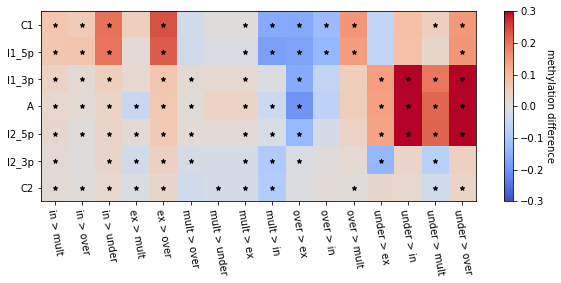

In [143]:

# as heatmap with methylation difference 
a = np.array([meth_in_to_mult, meth_in_to_over, meth_in_to_under, meth_ex_to_mult, meth_ex_to_over, meth_mult_to_over, meth_mult_to_under, meth_mult_to_ex, meth_mult_to_in, meth_over_to_ex, meth_over_to_in, meth_over_to_mult,  meth_under_to_ex, meth_under_to_in, meth_under_to_mult, meth_under_to_over],dtype=float)
a=a.T
y_name = ["in > mult", "in > over", "in > under", "ex > mult", "ex > over", "mult > over", "mult > under", "mult > ex", "mult > in", "over > ex", "over > in", "over > mult",  "under > ex", "under > in", "under > mult", "under > over"]
fig = plt.figure(figsize=(10, 3.5))
ax= plt.subplot(111) 
plt.imshow(a, cmap='coolwarm', vmin=-0.3, vmax=0.3)
ax.set_xticks(range(17))
ax.set_yticks(range(7))

ax.set_xticklabels(y_name, rotation=-80)
ax.set_yticklabels(lables2)
cbar = plt.colorbar()
cbar.set_label("methylation difference", rotation=-90, labelpad=10)
for significant in list_all_signi:
    for entry in significant:
        ax.scatter(entry[1], entry[0], marker='*', s=20, color='black')
        
